# Імпортую бібліотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from scipy.cluster.hierarchy import dendrogram, linkage

# Зчитую датасети

In [2]:
df_zp_g=pd.read_excel('zp_galuzi.xlsx')
df_zp_r=pd.read_excel('zp_region.xlsx')
df_zp_s=pd.read_excel('zp_stat.xlsx')
df_rk_g=pd.read_excel('rk_galuzi.xlsx')
df_rk_r=pd.read_excel('rk_region.xlsx')

# Допоміжні функції

In [3]:
def display_full(x):
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.width', 2000,
                           'display.float_format', '{:20,.2f}'.format,
                           'display.max_colwidth', None):
        display(x)

In [4]:
def drop_column(df,column):
    columns = df.columns
    index = columns.get_loc(column)
    df = df.drop(columns[index], axis=1)
    temp_df = df
    return temp_df

In [5]:
def create_temp_df(df1, df2, column_from_df1, column_from_df2, time_period):
    temp_df = pd.DataFrame()
    if time_period == 'Month':
        temp_df[time_period] = df1[time_period]
        temp_df[column_from_df1] = df1[column_from_df1]
        temp_df[column_from_df2] = df2[column_from_df2]
    elif time_period == 'Quarter':
        temp_df[time_period] = df1[time_period]
        temp_df[column_from_df1] = df1[column_from_df1]
        temp_df[column_from_df2] = df2[column_from_df2].values
    return temp_df

In [6]:
def convert_to_quarters(df):
    df = df.rename(columns={"Month": "Quarter"})
    quarters = [f"{i} quarter" for i in range(1, 5)]
    quarterly_data = []
    for i in range(0, len(df), 3):
        quarter_data = df.iloc[i:i+3].copy()
        quarter_data["Quarter"] = quarters[i // 3]
        quarterly_data.append(quarter_data)
    quarterly_df = pd.concat(quarterly_data, ignore_index=True)
    quarterly_df = quarterly_df.groupby("Quarter").sum().reset_index()   
    return quarterly_df

In [7]:
def multiply_by_thousand(dataframe):
    multiplied_df = dataframe.copy()
    multiplied_df.iloc[:, 1:] = multiplied_df.iloc[:, 1:] * 1000
    return multiplied_df

# Візуалізаційні функції

In [8]:
def gistograma(df,column,time_period):
    plt.bar(df[time_period],df[column])
    plt.xticks(df[time_period],rotation=90)
    plt.ylabel(column)
    plt.xlabel(time_period)

In [9]:
def pie_chart(df, time_period):
    if 'Month' in df.columns:
        selected_data = df[df['Month'] == time_period]
    elif 'Quarter' in df.columns:
        selected_data = df[df['Quarter'] == time_period]
    else:
        print("Invalid dataframe format")
        return
    names = selected_data.columns[2:]
    values = selected_data.iloc[0, 2:].astype(str).str.replace(',', '').astype(float)
    plt.figure(figsize=(8, 8))
    patches, _, _ = plt.pie(values, labels=['']*len(names), autopct='%1.1f%%')
    plt.title(f"{time_period}")
    plt.legend(patches, names, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.axis('equal')
    plt.show()

In [10]:
def dynamic(df,time_period):
    plt.figure(figsize=(10, 6))
    for column in df.columns[1:]:
        plt.plot(df[time_period], df[column], label=column)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xticks(rotation=90)
    plt.xlabel(time_period)
    plt.ylabel('Revenue, UAH')
    plt.title('Revenue Dynamics')
    plt.show()
        

In [11]:
def comparison (df,column1,column2,time_period):
    plt.figure(figsize=(10, 6))
    plt.plot(df[time_period], df[column1], label=column1)
    plt.plot(df[time_period], df[column2], label=column2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xticks(rotation=90)
    plt.xlabel(time_period)
    plt.ylabel('Revenue, UAH')
    plt.title('Comparison of {} and {}'.format(column1, column2))
    plt.show()

# Статистичні функції

In [12]:
def calculate_expected_values(df):
    df_values = df.iloc[:, 1:]
    for column in df_values.columns:
        if df_values[column].dtype != object:
            continue
        df_values[column] = df_values[column].str.replace(',', '').astype(float)
    expected_values = df_values.mean()
    return expected_values

In [13]:
def calculate_variance(df):
    df_values = df.iloc[:, 1:]
    for column in df_values.columns:
        if df_values[column].dtype != object:
            continue
        df_values[column] = df_values[column].str.replace(',', '').astype(float)
    variances = df_values.var()
    return variances

In [14]:
def calculate_standard_deviation(df):
    df_values = df.iloc[:, 1:]
    for column in df_values.columns:
        if df_values[column].dtype != object:
            continue
        df_values[column] = df_values[column].str.replace(',', '').astype(float)
    std_deviations = df_values.std()
    return std_deviations

In [15]:
def employee_percentage(df, column):
    initial_employees = df.iloc[0][column]
    final_employees = df.iloc[-1][column]
    growth_rate = (final_employees - initial_employees) / initial_employees * 100
    quarters = df['Quarter'].tolist()
    employees = df[column].tolist()
    plt.plot(quarters, employees)
    plt.xlabel('Quarter')
    plt.ylabel('Amount of employees')
    plt.title('Dynamic')
    plt.xticks(rotation=90)
    plt.show()
    growth_rate_string = f"Percentage'{column}': {growth_rate:.2f}%"
    print(growth_rate_string)
    return growth_rate

In [16]:
def salary_growth(df, inflation_list, column):
    initial_salary = df.iloc[0][column]
    final_salary = df.iloc[-1][column]
    growth_rate = (final_salary - initial_salary) / initial_salary * 100
    months = df['Month'].tolist()
    salaries = df[column].tolist()
    plt.plot(months, salaries)
    plt.xlabel('Month')
    plt.ylabel('Average salary')
    plt.title('Dynamic for Average salary')
    plt.xticks(rotation=90)
    plt.show()
    growth_rate_string = f"Percentage of average salary growth: {growth_rate:.2f}%"
    print(growth_rate_string)
    return growth_rate

In [17]:
inflation_list = ['101.3', '101.0', '101.7', '100.7', '101.3', '100.2', '100.1', '99.8', '101.2', '100.9', '100.8', '100.6']

# Поепередній огляд датафреймів по заробітним платам

In [18]:
display_full(df_zp_g)

,Month,Average by type of activity,"Agriculture, forestry and fishing",Manufacturing,Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,"Transportation and warehousing, postal and courier activities",Land transport and transport via pipelines,Water transport,Air transport,Warehousing and support activities for transportation,Postal and courier activities,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities,Public administration and defence; compulsory social security,Education,Human health and social work activities,"Arts, sport, entertainment and recreation","arts, entertainment and recreation activities","Libraries, archives, museums and other cultural activities",Other service activities
0,January/UAH,"12,336.78","9,564.56","13,373.67","9,238.37","11,897.86","12,209.70","11,765.71","12,603.53","22,393.93","13,157.74","7,523.96","6,647.06","21,941.06","24,095.36","9,683.13","16,602.43","10,303.79","15,230.55","10,310.43","10,572.79","10,436.53","9,706.14","8,971.19","11,656.71"
1,February/UAH,"12,548.85","9,596.17","13,196.58","9,844.68","12,245.56","11,728.02","10,939.90","12,251.75","22,613.22","12,846.29","7,435.67","7,892.34","23,001.27","22,319.01","10,379.76","17,550.21","10,414.19","15,929.49","11,025.77","10,959.74","11,887.52","10,927.01","9,302.29","11,648.07"
2,March/UAH,"13,612.21","10,684.76","14,994.50","10,297.28","13,854.04","12,539.86","11,545.69","13,947.39","25,219.31","13,705.58","8,349.33","7,748.78","25,504.46","24,279.16","10,354.88","18,767.51","10,978.86","16,504.92","10,959.14","12,246.33","11,729.25","10,643.98","9,814.55","13,347.91"
3,April/UAH,"13,543.08","12,451.22","14,471.17","10,954.89","12,692.60","13,204.61","13,100.55","15,080.88","25,651.53","13,851.45","7,745.07","6,979.35","27,101.05","23,556.85","10,861.29","21,882.71","10,677.56","17,116.40","10,858.92","11,734.77","11,053.51","9,794.37","9,339.80","12,420.12"
4,May/UAH,"13,498.94","11,800.87","14,295.81","10,919.75","13,166.87","13,165.00","12,526.68","14,897.47","28,041.81","14,119.26","7,848.51","8,875.30","25,264.51","21,965.16","11,138.85","17,744.55","10,725.57","17,931.12","11,579.38","11,526.25","12,059.05","10,832.62","10,301.07","12,349.49"
5,June/UAH,"14,312.85","11,875.19","14,709.88","11,301.81","13,340.77","12,983.81","12,161.79","14,766.07","29,288.32","13,810.01","8,669.14","8,922.28","26,197.07","22,690.93","11,208.43","19,052.33","11,034.07","19,867.78","14,158.09","12,089.52","13,259.54","12,262.69","11,094.14","14,049.38"
6,July/UAH,"14,345.13","12,732.55","15,246.91","11,838.54","13,505.65","15,256.65","14,681.47","15,355.78","29,975.87","16,646.54","7,869.19","8,870.96","24,945.61","24,489.32","11,489.56","19,203.42","11,282.80","20,782.30","11,894.82","11,175.39","13,145.42","12,116.94","11,112.96","15,545.85"
7,August/UAH,"13,997.00","12,252.85","15,056.99","11,867.82","13,684.54","15,072.35","14,793.40","15,237.96","30,652.63","16,103.59","7,888.11","9,787.71","24,812.74","23,536.70","11,383.94","19,170.22","11,345.11","21,207.07","10,472.55","10,898.24","12,489.75","11,105.93","10,656.15","13,051.08"
8,September/UAH,"14,239.30","12,979.60","15,406.07","12,401.60","13,828.29","14,496.25","13,627.37","15,399.69","29,833.00","15,749.00","8,757.22","9,039.36","25,427.23","22,547.38","11,371.43","19,513.89","11,294.93","18,841.98","12,333.61","10,585.54","13,226.80","11,432.19","10,878.95","13,089.94"
9,October/UAH,"14,044.81","13,304.07","14,993.45","11,806.61","13,744.67","14,568.48","13,790.14","14,175.03","30,135.95","15,835.12","8,313.58","8,851.57","25,195.63","23,641.88","11,195.24","19,047.05","11,414.94","18,577.80","11,532.00","11,159.61","12,470.65","11,091.43","10,134.38","13,095.59"


In [19]:
display_full(df_zp_r)

,Month,Average by region,Vinnytsya,Volyn,Dnipropetrovsk,Donetsk,Zhytomyr,Zakarpattya,Zaporizhzhya,Ivano-Frankivsk,Kyiv,Kirovohrad,Luhansk,Lviv,Mykolayiv,Odesa,Poltava,Rivne,Sumy,Ternopil,Kharkiv,Kherson,Khmelnytskiy,Cherkasy,Chernivtsi,Chernihiv,City of Kyiv
0,January/UAH,"12,336.78","10,750.85","10,047.56","12,743.52","13,785.71","10,111.22","10,416.64","12,542.14","10,558.19","12,644.59","9,779.83","10,324.10","11,037.88","12,534.96","10,995.02","11,352.79","11,405.97","10,306.42","9,921.72","10,363.84","9,971.03","10,725.16","10,460.20","9,696.30","9,876.93","17,533.23"
1,February/UAH,"12,548.85","10,927.35","10,231.87","12,321.54","13,223.52","10,205.71","11,043.31","12,422.04","10,771.53","12,746.98","9,902.60","11,175.53","11,139.03","12,392.33","11,232.59","11,538.40","11,266.90","10,407.85","10,280.07","10,795.92","10,105.92","10,941.95","10,587.50","10,155.70","10,122.19","18,504.48"
2,March/UAH,"13,612.21","11,695.79","11,031.38","13,676.58","15,907.12","10,674.88","11,538.06","13,721.29","11,493.24","13,438.09","10,705.76","11,258.92","11,936.88","13,461.90","11,889.01","12,404.32","12,879.42","11,016.41","10,972.55","11,312.97","11,318.77","11,892.49","11,461.92","10,860.75","10,721.59","20,132.13"
3,April/UAH,"13,543.08","11,976.54","10,776.77","13,129.05","13,885.90","11,201.95","11,608.37","13,193.46","11,906.07","13,907.56","10,779.52","11,696.01","12,051.96","12,650.58","11,624.14","12,574.56","11,811.59","11,303.18","11,612.85","11,765.96","10,647.11","11,801.28","11,690.16","10,826.37","11,173.77","20,421.76"
4,May/UAH,"13,499.00","12,247.00","10,890.00","13,460.00","14,457.00","11,396.00","11,743.00","13,472.00","11,681.00","13,850.00","10,903.00","11,961.00","12,065.00","13,113.00","11,994.00","12,584.00","11,997.00","11,524.00","11,230.00","11,674.00","11,113.00","11,757.00","11,876.00","10,941.00","11,182.00","19,287.00"
5,June/UAH,"14,312.85","12,789.18","12,126.08","13,831.54","14,987.65","12,221.37","13,019.66","13,895.10","12,904.73","14,679.48","11,496.76","12,753.77","12,902.72","14,043.93","12,841.52","13,088.23","13,005.12","12,297.21","12,293.41","12,298.13","12,109.60","12,965.11","12,447.56","12,131.78","12,127.97","20,455.06"
6,July/UAH,"14,345.13","12,781.73","11,740.19","13,891.77","15,287.26","12,044.46","12,745.17","14,106.57","12,625.10","14,543.19","11,684.45","12,555.88","12,924.42","14,071.88","12,609.40","13,320.65","12,865.89","12,347.57","11,742.54","12,374.08","11,552.23","12,338.34","12,306.59","11,349.93","11,546.61","20,956.46"
7,August/UAH,"13,997.00","12,425.99","11,254.16","13,956.80","14,847.71","11,624.00","12,221.38","13,952.12","11,777.92","14,227.69","11,088.00","11,810.69","12,724.44","13,751.06","12,359.09","13,049.52","12,507.15","12,106.83","11,282.83","12,071.93","11,417.70","12,055.06","11,845.45","10,811.39","11,424.86","20,358.12"
8,September/UAH,"14,239.30","12,690.01","11,677.26","13,768.45","15,147.68","11,878.92","12,314.87","14,043.87","12,369.39","14,678.33","11,558.90","12,541.12","13,018.47","14,143.65","12,256.90","13,293.13","13,217.66","11,966.10","11,532.49","12,626.70","11,512.05","12,468.67","11,892.17","10,976.16","11,497.46","20,657.79"
9,October/UAH,"14,044.81","13,054.47","11,516.80","13,730.43","14,791.01","11,679.43","12,057.58","13,486.17","11,911.22","14,553.94","11,457.11","12,097.22","12,548.60","13,591.94","12,244.63","13,396.81","12,440.37","12,004.97","11,615.46","12,122.41","11,470.84","12,222.87","12,275.56","10,878.45","11,533.91","20,481.39"


In [20]:
display_full(df_zp_s)

,Month,Average by type of activity(men),"Agriculture, forestry and fishing (men)",Manufacturing(men),Construction(men),Wholesale and retail trade; repair of motor vehicles and motorcycles (men),"Transportation and warehousing, postal and courier activities(men)",Land transport and transport via pipelines(men),Water transport(men),Air transport(men),Warehousing and support activities for transportation(men),Postal and courier activities(men),Accommodation and food service activities (men),Information and communication (men),Financial and insurance activities (men),Real estate activities (men),"Professional, scientific and technical activities (men)",Administrative and support service activities (men),Public administration and defence; compulsory social security (men),Education(men),Human health and social work activities (men),"Arts, sport, entertainment and recreation (men)","arts, entertainment and recreation activities (men)","Libraries, archives, museums and other cultural activities(men)",Other service activities (men),Average by type of activity(women),"Agriculture, forestry and fishing (women)",Manufacturing(women),Construction(women),Wholesale and retail trade; repair of motor vehicles and motorcycles (women),"Transportation and warehousing, postal and courier activities(women)",Land transport and transport via pipelines(women),Water transport(women),Air transport(women),Warehousing and support activities for transportation(women),Postal and courier activities(women),Accommodation and food service activities (women),Information and communication (women),Financial and insurance activities (women),Real estate activities (women),"Professional, scientific and technical activities (women)",Administrative and support service activities (women),Public administration and defence; compulsory social security (women),Education(women),Human health and social work activities (women),"Arts, sport, entertainment and recreation (women)","arts, entertainment and recreation activities (women)","Libraries, archives, museums and other cultural activities(women)",Other service activities (women)
0,January/UAH,"14,008.94","10,162.79","15,041.40","9,791.70","13,766.28","13,013.22","11,489.00","12,590.50","26,647.57","13,853.49","10,524.88","7,928.89","26,584.52","29,656.16","10,195.60","19,741.94","10,499.75","16,646.32","10,951.33","12,562.37","14,551.12","11,846.68","9,922.67","12,548.38","11,520.14","9,046.82","11,215.28","9,160.44","11,208.83","10,252.28","10,781.57","13,002.99","17,110.20","11,363.89","7,096.56","7,017.11","19,276.13","20,315.13","9,761.88","15,185.43","10,470.61","15,079.41","10,584.55","10,715.85","9,543.10","9,515.02","9,017.28","11,414.01"
1,February/UAH,"14,191.09","10,294.93","15,312.32","9,919.02","14,014.24","13,169.88","11,627.31","12,826.03","26,998.48","14,047.78","10,692.38","8,043.12","26,765.10","30,045.75","10,372.30","20,199.39","10,563.79","16,943.87","11,050.98","12,782.78","14,709.25","12,045.22","10,066.11","12,705.72","11,669.87","9,164.40","11,417.25","9,270.78","11,418.60","10,387.32","10,932.83","13,209.87","17,356.71","11,441.09","7,189.73","7,138.65","19,723.02","20,454.35","9,821.44","15,456.90","10,565.86","15,343.93","10,699.63","10,895.40","9,680.99","9,634.30","9,155.76","11,624.46"
2,March/UAH,"14,373.24","10,427.07","15,583.24","10,046.34","14,262.20","13,326.54","11,765.62","13,061.56","27,349.39","14,242.07","10,859.88","8,157.35","26,945.68","30,435.34","10,549.00","20,656.84","10,627.83","17,241.42","11,150.63","13,003.19","14,867.38","12,243.76","10,209.55","12,863.06","11,819.60","9,281.98","11,619.22","9,381.12","11,628.37","10,522.36","11,084.09","13,416.75","17,603.22","11,518.29","7,282.90","7,260.19","20,169.91","20,593.57","9,881.00","15,728.37","10,661.11","15,608.45","10,814.71","11,074.95","9,818.88","9,753.58","9,294.24","11,834.91"
3,April/UAH,"15,012.49","12,625.56","15,776.84","11,212.68","14,297.06","14,145.22","12,751.07","14,796.68","33,260.46","14,717.68","11,275.48

# Розбиваю датафрейми за статею

In [21]:
df_zp_men=df_zp_s.iloc[:,:25]
df_zp_women=df_zp_s.iloc[:,25:]
df_zp_women.insert(0, 'Month', df_zp_men['Month'])

# Статистичний аналіз для датасетів по заробітним платамв

In [22]:
calculate_expected_values(df_zp_r)

Average by region    14017.868333
Vinnytsya            12489.130833
Volyn                11454.790833
Dnipropetrovsk       13679.441667
Donetsk              14860.088333
Zhytomyr             11633.400833
Zakarpattya          12245.884167
Zaporizhzhya         13788.428333
Ivano-Frankivsk      11990.894167
Kyiv                 14286.128333
Kirovohrad           11178.078333
Luhansk              12185.297500
Lviv                 12529.295833
Mykolayiv            13811.420833
Odesa                12325.808333
Poltava              12989.660833
Rivne                12766.549167
Sumy                 11850.705000
Ternopil             11590.938333
Kharkiv              12053.398333
Kherson              11398.783333
Khmelnytskiy         12322.905000
Cherkasy             11954.165000
Chernivtsi           11190.974167
Chernihiv            11364.348333
City of Kyiv         20557.528333
dtype: float64

In [23]:
calculate_variance(df_zp_women)

Average by type of activity(women)                                              6.433555e+05
Agriculture, forestry and fishing (women)                                       1.107887e+06
Manufacturing(women)                                                            5.765838e+05
Construction(women)                                                             4.125999e+05
Wholesale and retail trade; repair of motor vehicles and motorcycles (women)    4.453016e+05
Transportation and warehousing, postal and courier activities(women)            1.014430e+06
Land transport and transport via pipelines(women)                               1.289535e+06
Water transport(women)                                                          5.938924e+05
Air transport(women)                                                            1.318791e+07
Warehousing and support activities for transportation(women)                    1.313208e+06
Postal and courier activities(women)                                  

In [24]:
calculate_standard_deviation(df_zp_women)

Average by type of activity(women)                                               802.094427
Agriculture, forestry and fishing (women)                                       1052.562158
Manufacturing(women)                                                             759.331156
Construction(women)                                                              642.339380
Wholesale and retail trade; repair of motor vehicles and motorcycles (women)     667.309211
Transportation and warehousing, postal and courier activities(women)            1007.189206
Land transport and transport via pipelines(women)                               1135.576793
Water transport(women)                                                           770.644118
Air transport(women)                                                            3631.516313
Warehousing and support activities for transportation(women)                    1145.952862
Postal and courier activities(women)                                            

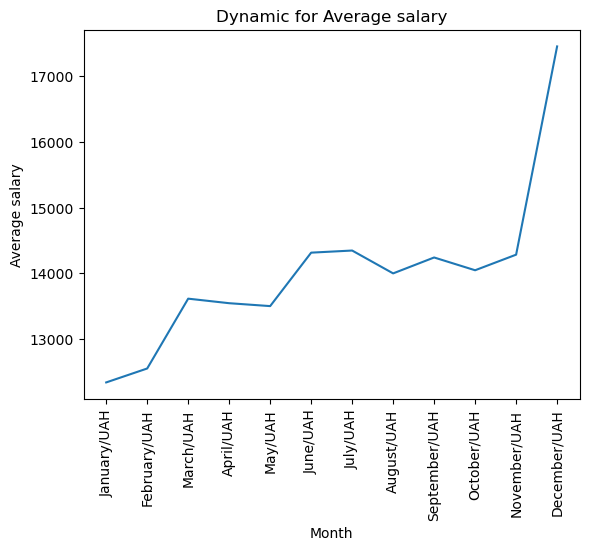

Percentage of average salary growth: 41.47%


41.473139668535865

In [25]:
salary_growth(df_zp_g, inflation_list,'Average by type of activity')

# Візуальний аналіз для датасетів по заробітним платам

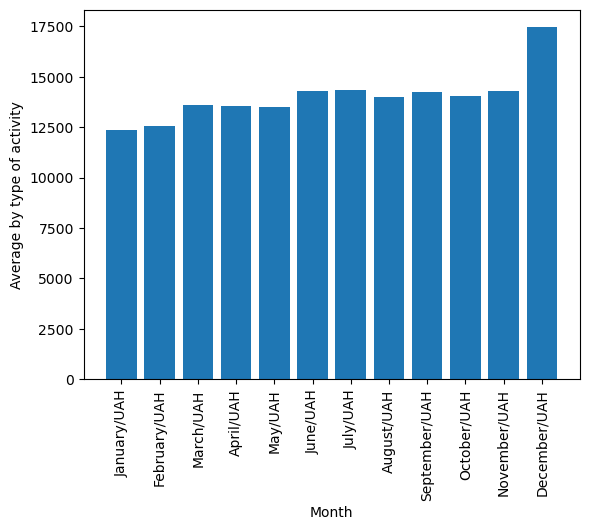

In [26]:
gistograma(df_zp_g,'Average by type of activity','Month')

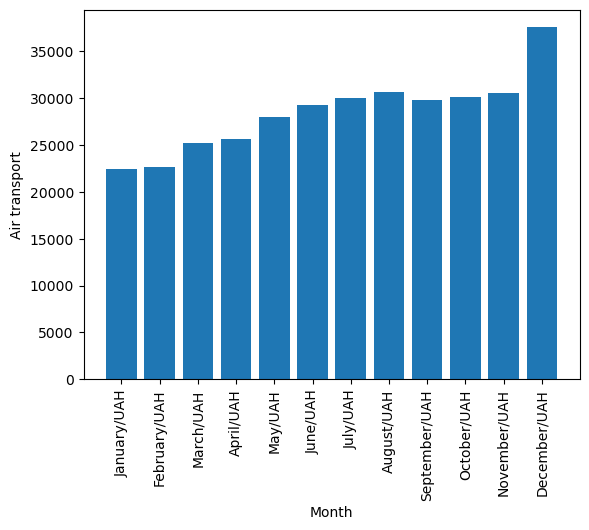

In [27]:
gistograma(df_zp_g,'Air transport','Month')

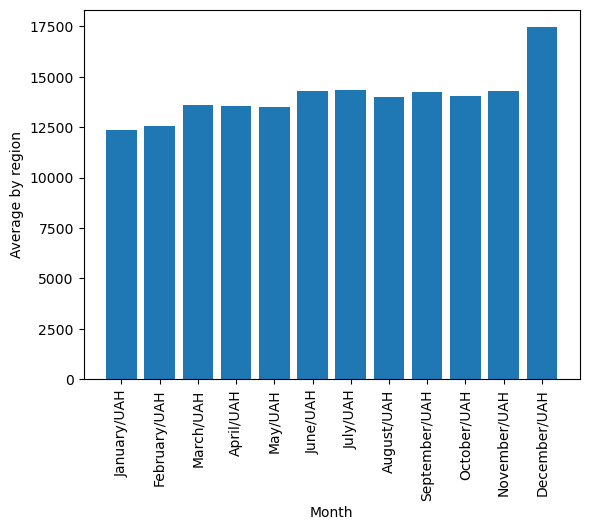

In [28]:
gistograma(df_zp_r,'Average by region','Month')

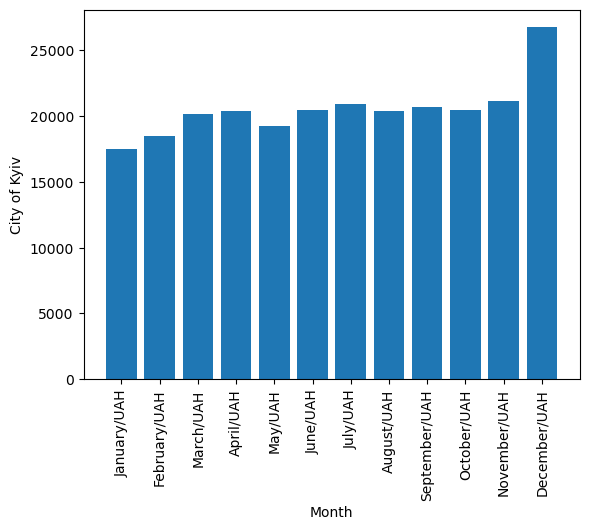

In [29]:
gistograma(df_zp_r,'City of Kyiv','Month')

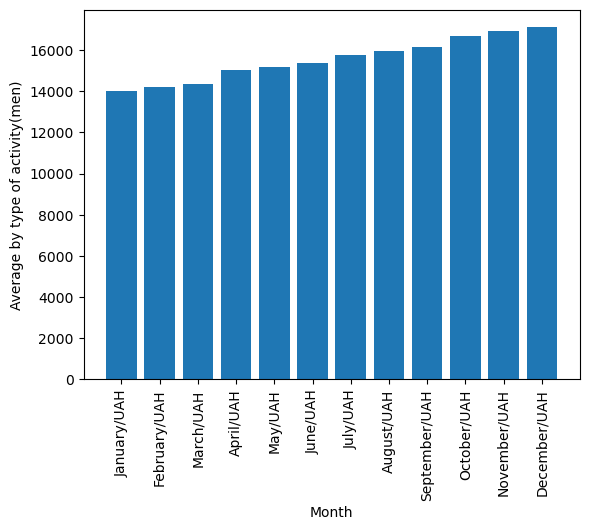

In [30]:
gistograma(df_zp_men,'Average by type of activity(men)','Month')

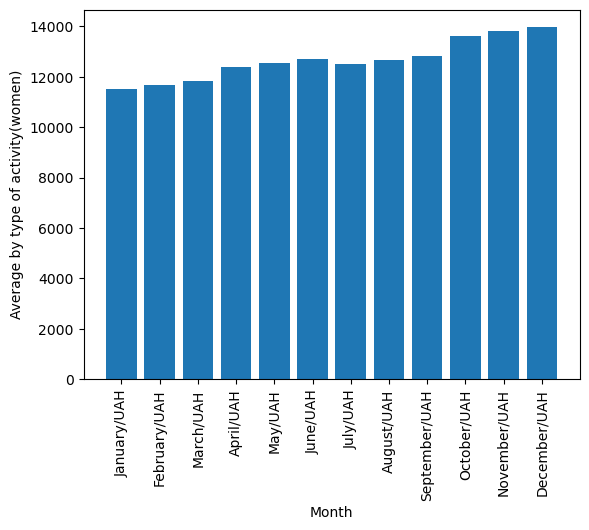

In [31]:
gistograma(df_zp_women,'Average by type of activity(women)','Month')

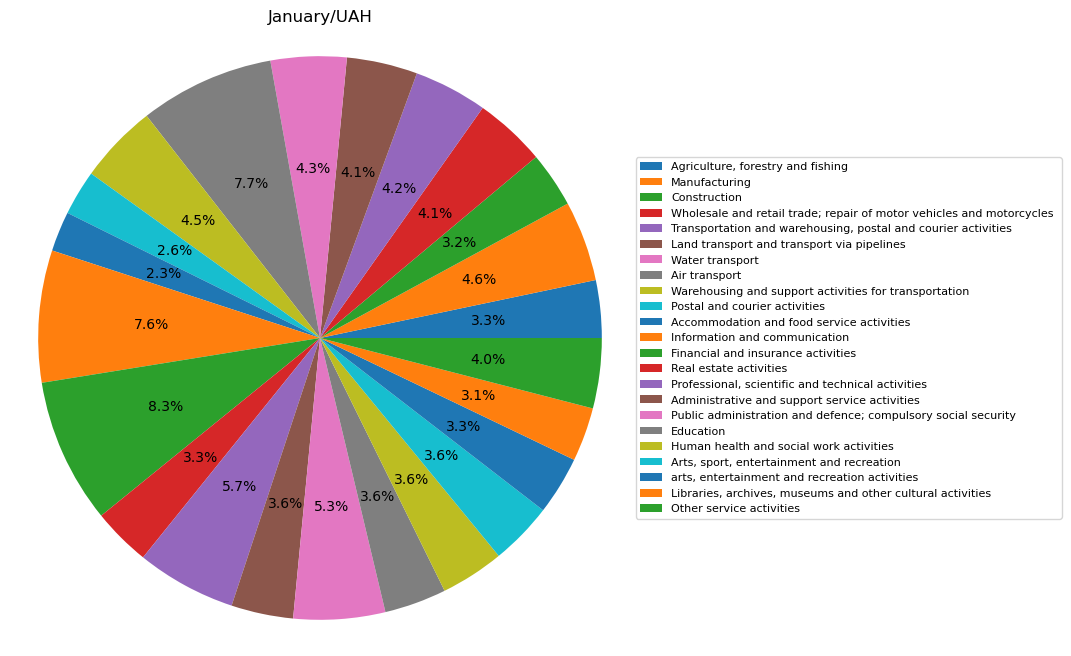

In [32]:
pie_chart(df_zp_g, 'January/UAH')

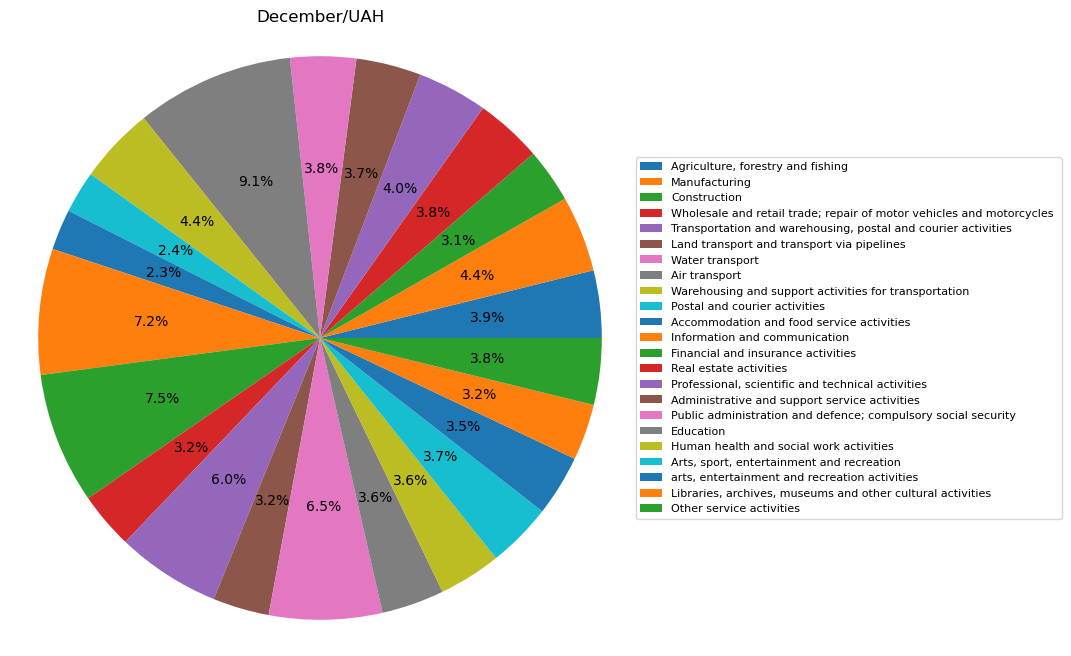

In [33]:
pie_chart(df_zp_g,'December/UAH')

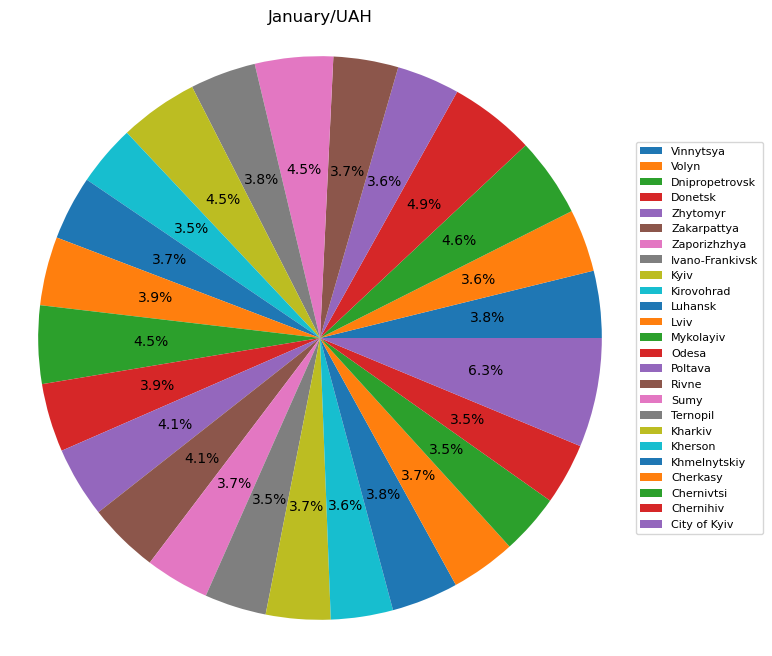

In [34]:
pie_chart(df_zp_r,'January/UAH')

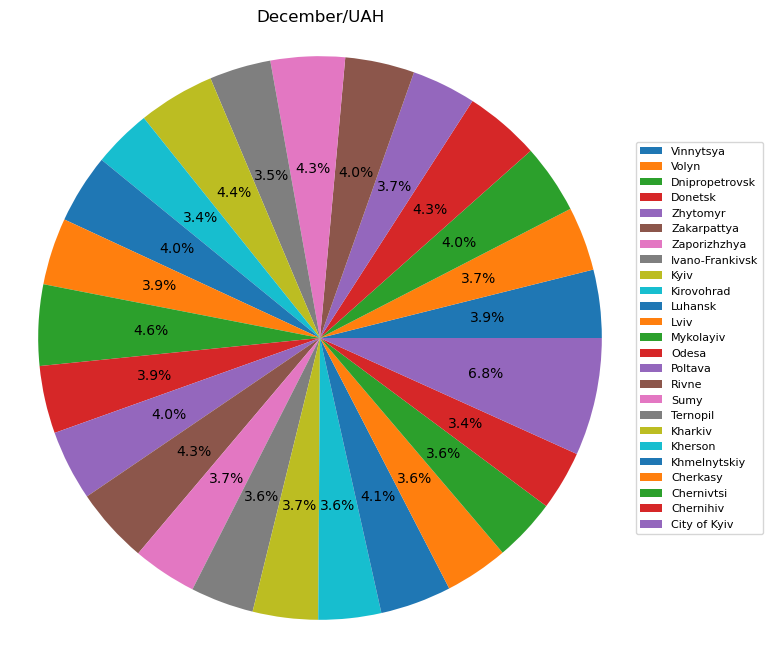

In [35]:
pie_chart(df_zp_r,'December/UAH')

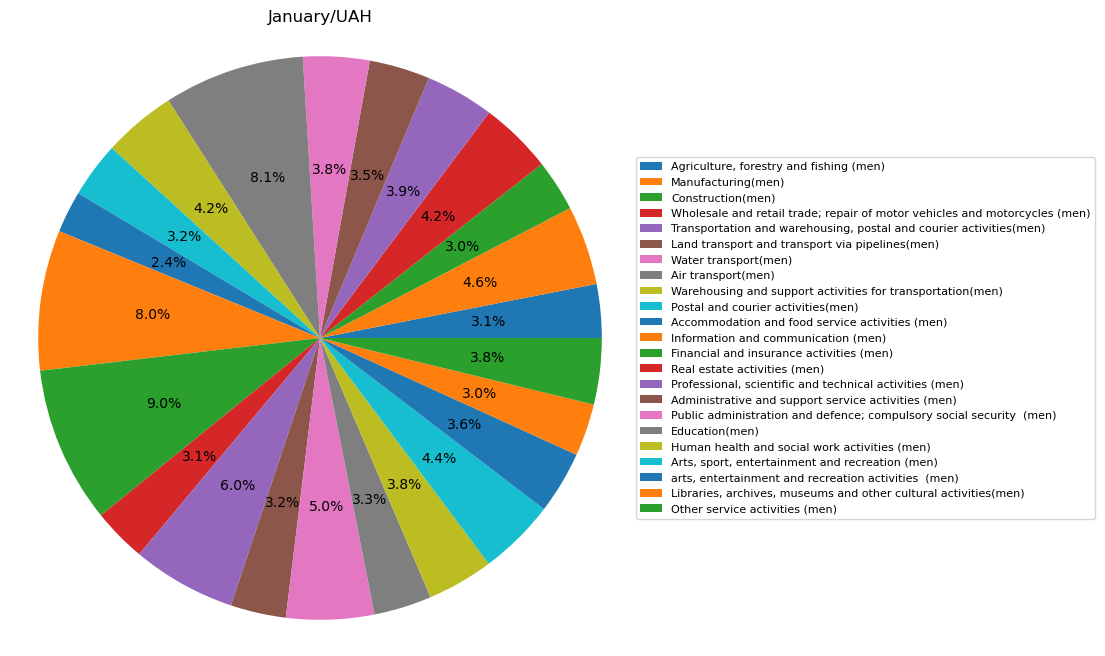

In [36]:
pie_chart(df_zp_men,'January/UAH')

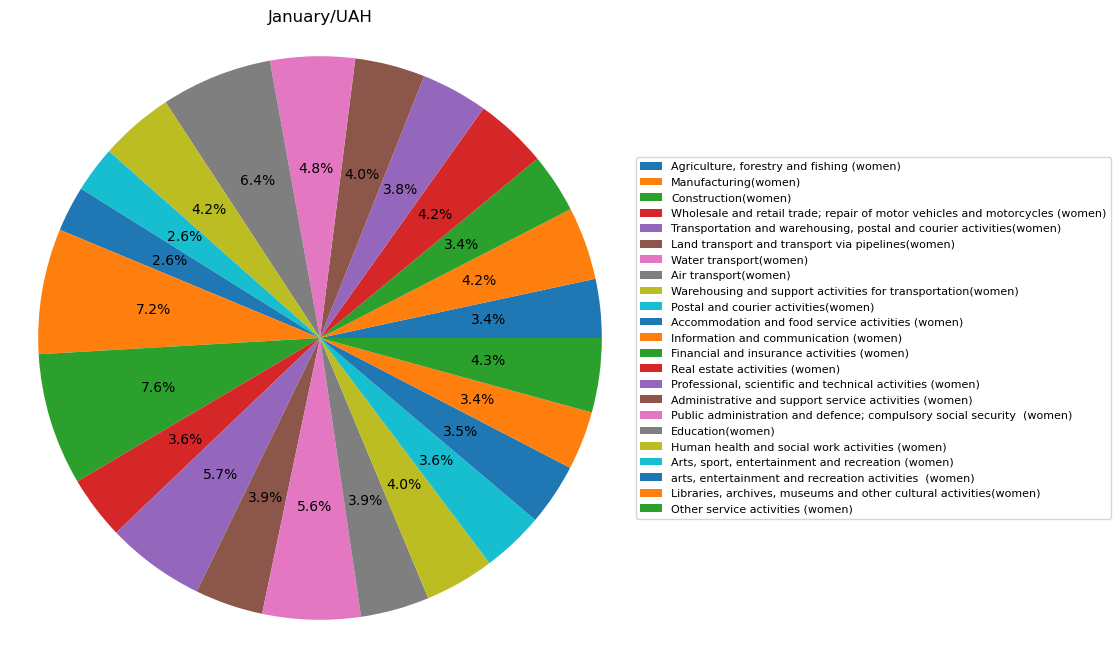

In [37]:
pie_chart(df_zp_women,'January/UAH')

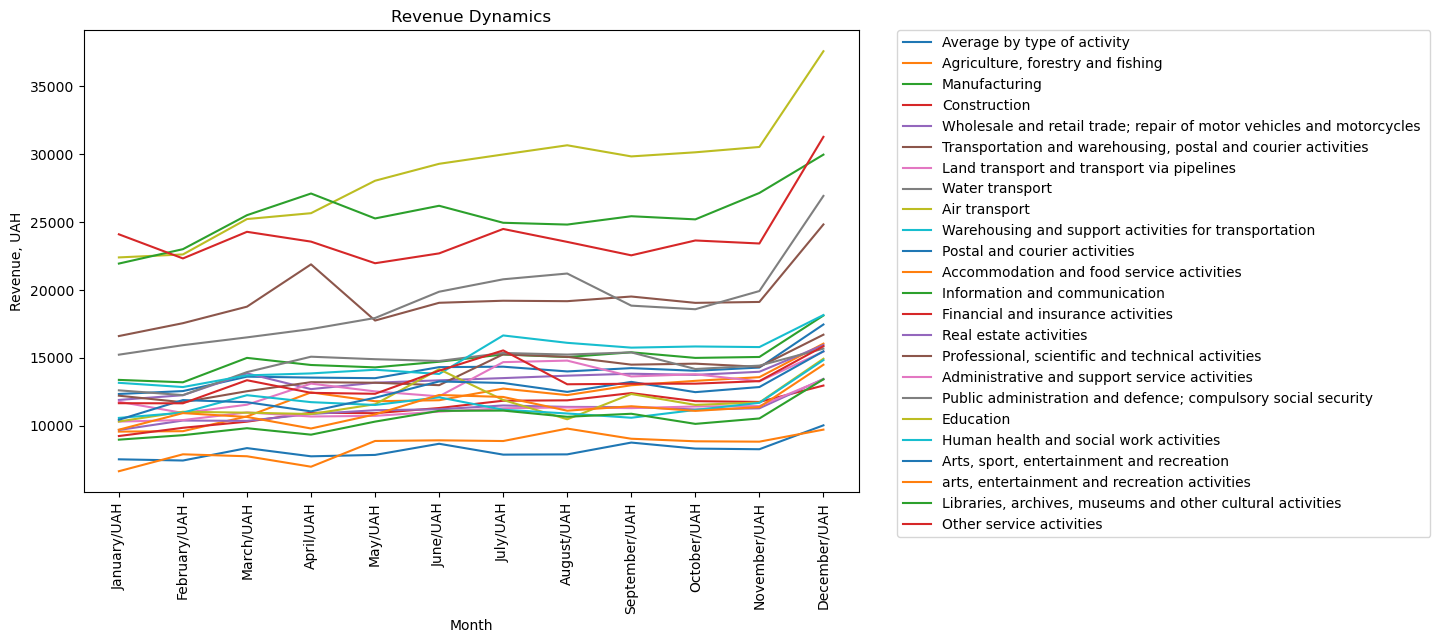

In [38]:
dynamic(df_zp_g,'Month')

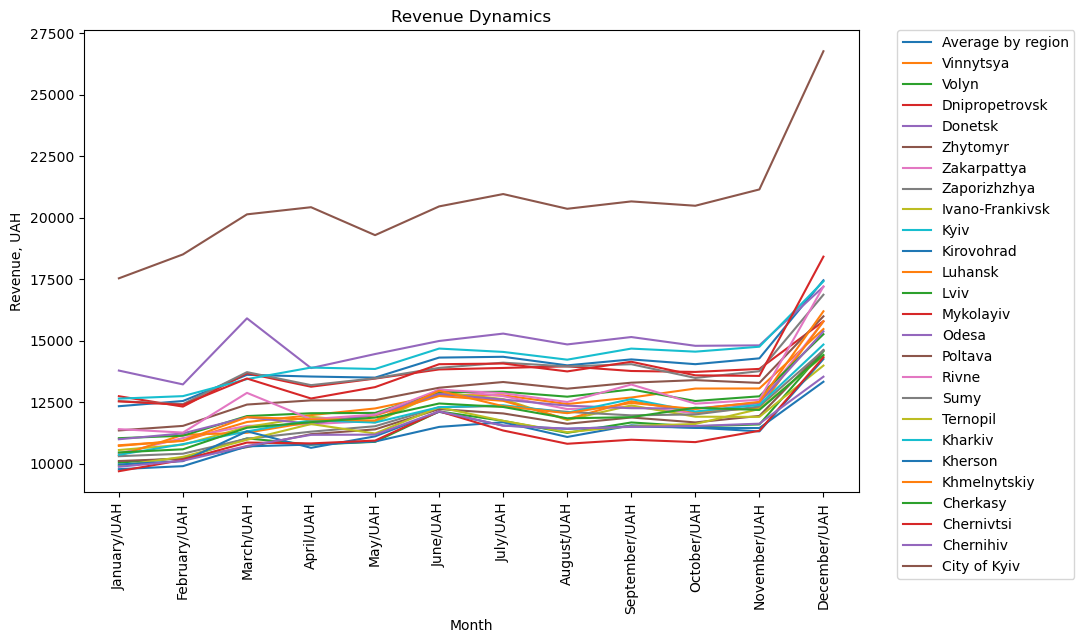

In [39]:
dynamic(df_zp_r,'Month')

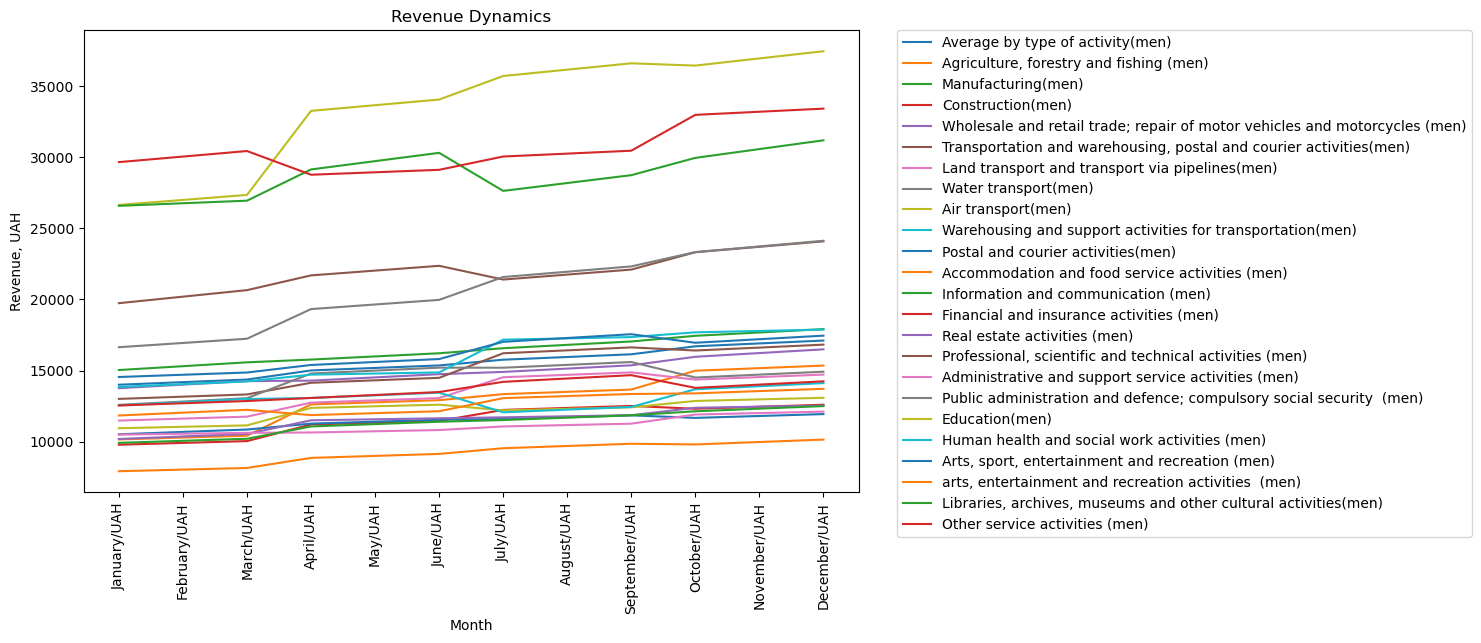

In [40]:
dynamic(df_zp_men,'Month')

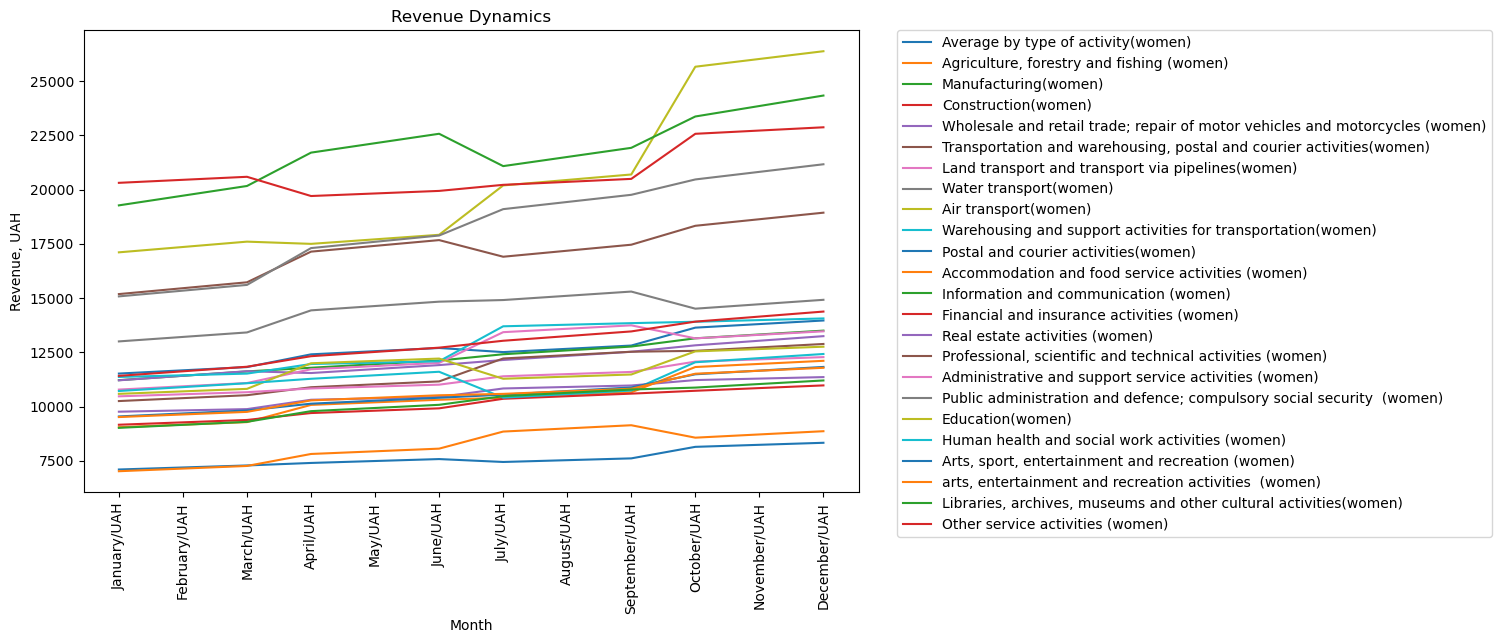

In [41]:
dynamic(df_zp_women,'Month')

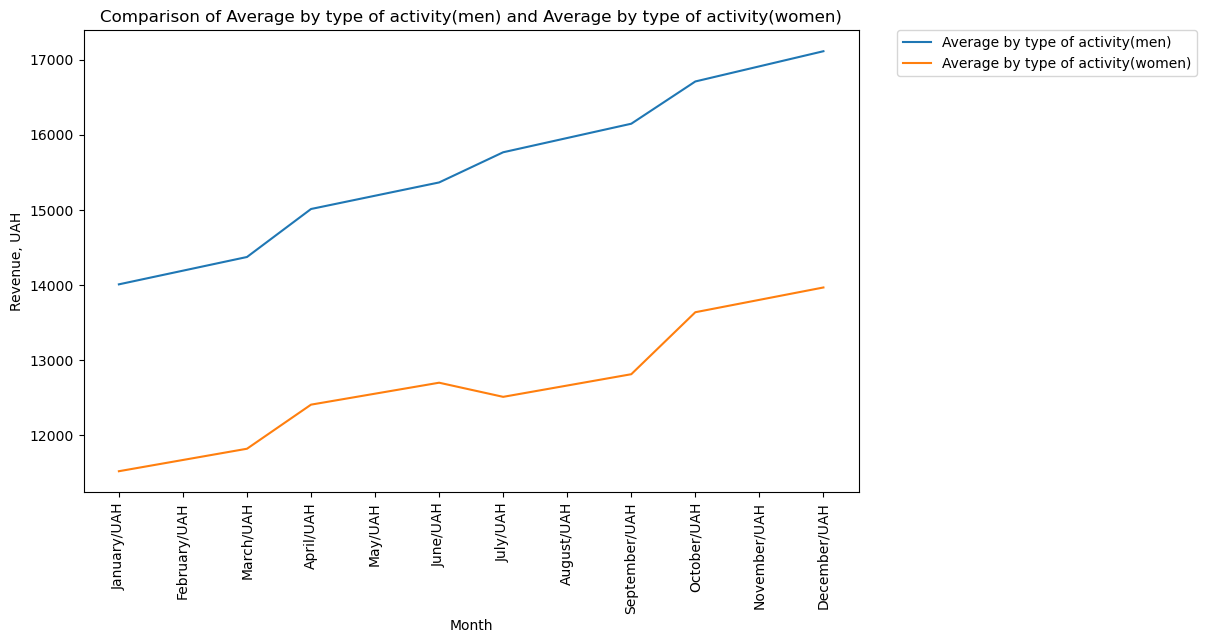

In [42]:
comparison(create_temp_df(df_zp_men, df_zp_women, 'Average by type of activity(men)', 'Average by type of activity(women)', 'Month'), 'Average by type of activity(men)', 'Average by type of activity(women)', 'Month')

# Розіб'ю датафрейми по руху кадрів за категоріями

In [43]:
df_rk_g_accepted = df_rk_g[df_rk_g['Parameter'].str.contains('Accepted')]
df_rk_g_quitted = df_rk_g[df_rk_g['Parameter'].str.contains('Quitted')]
df_rk_g_turnover = df_rk_g[df_rk_g['Parameter'].str.contains('Employee turnover')]
df_rk_g_cuts = df_rk_g[df_rk_g['Parameter'].str.contains('Cuts in staff')]

df_rk_g_accepted = df_rk_g_accepted.drop('Parameter', axis=1)
df_rk_g_quitted = df_rk_g_quitted.drop('Parameter', axis=1)
df_rk_g_turnover = df_rk_g_turnover.drop('Parameter', axis=1)
df_rk_g_cuts = df_rk_g_cuts.drop('Parameter', axis=1)


In [44]:
df_rk_r_accepted = df_rk_r[df_rk_r[' Parameter'].str.contains('Accepted')]
df_rk_r_quitted = df_rk_r[df_rk_r[' Parameter'].str.contains('Quitted')]
df_rk_r_turnover = df_rk_r[df_rk_r[' Parameter'].str.contains('Employee turnover')]
df_rk_r_cuts = df_rk_r[df_rk_r[' Parameter'].str.contains('Cuts in staff')]

df_rk_r_accepted = df_rk_r_accepted.drop(' Parameter', axis=1)
df_rk_r_quitted = df_rk_r_quitted.drop(' Parameter', axis=1)
df_rk_r_turnover = df_rk_r_turnover.drop(' Parameter', axis=1)
df_rk_r_cuts = df_rk_r_cuts.drop(' Parameter', axis=1)

In [45]:
df_rk_g_accepted.reset_index()
df_rk_g_quitted.reset_index()
df_rk_g_turnover.reset_index()
df_rk_g_cuts.reset_index()
df_rk_r_accepted.reset_index()
df_rk_r_quitted.reset_index()
df_rk_r_turnover.reset_index()
df_rk_r_cuts.reset_index()

,index,Quarter,Ukraine,Vinnytsya,Volyn,Dnipropetrovsk,Donetsk,Zhytomyr,Zakarpattya,Zaporizhzhya,...,Rivne,Sumy,Ternopil,Kharkiv,Kherson,Khmelnytskiy,Cherkasy,Chernivtsi,Chernihiv,City of Kyiv
0,3,1 quarter,52.0,2.4,0.7,1.9,2.4,1.1,0.9,1.6,...,0.8,0.9,1.1,2.2,1.5,1.3,1.4,1.0,0.7,3.7
1,7,2 quarter,30.0,1.6,0.9,3.3,3.0,0.7,0.5,0.7,...,0.7,0.3,0.9,0.6,1.0,0.6,1.3,0.7,1.0,2.3
2,11,3 quarter,43.6,1.0,1.1,11.0,3.0,0.8,0.5,0.9,...,1.0,0.8,0.5,1.9,0.9,1.2,1.3,0.9,1.5,3.0
3,15,4 quartrer,46.6,1.3,1.2,6.6,2.5,0.8,0.2,1.6,...,1.5,1.3,1.0,2.6,0.8,1.4,1.1,1.1,1.3,2.5


# Поепередній огляд датафреймів по руху кадрів

In [46]:
display_full(df_rk_g_accepted)

,Quarter,Total,"Agriculture, forestry and fishing",Manufacturing,Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,"Transportation and warehousing, postal and courier activities",Land transport and transport via pipelines,Water transport,Air transport,Warehousing and support activities for transportation,Postal and courier activities,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities
0,1 quarter,530.30,46.50,98.90,21.70,76.90,35.10,14.00,0.20,0.40,15.70,4.70,8.80,6.90,10.70,3.90,10.60,18.70
4,2 quarter,485.70,69.60,107.90,29.20,90.70,37.70,15.40,0.30,0.70,16.30,5.10,13.60,7.20,11.00,4.50,9.70,20.40
8,3 quarter,553.60,38.30,125.10,23.50,103.30,43.40,17.90,0.40,0.90,18.60,5.60,17.60,8.20,23.90,4.60,10.70,18.60
12,4 quarter,468.70,24.00,109.40,24.90,95.90,38.00,13.90,0.40,0.70,16.90,6.10,8.20,7.90,14.80,4.00,10.40,15.20


In [47]:
display_full(df_rk_g_quitted)

,Quarter,Total,"Agriculture, forestry and fishing",Manufacturing,Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,"Transportation and warehousing, postal and courier activities",Land transport and transport via pipelines,Water transport,Air transport,Warehousing and support activities for transportation,Postal and courier activities,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities
1,1 quarter,489.90,35.10,109.00,19.40,87.70,42.30,18.80,0.30,0.40,17.30,5.40,8.20,8.70,12.50,4.70,11.40,21.20
5,2 quarter,545.20,30.60,138.50,22.40,102.00,45.50,19.30,0.30,0.60,19.70,5.60,11.20,9.20,14.70,5.70,12.80,20.10
9,3 quarter,592.90,32.10,137.00,24.80,104.70,49.30,20.10,0.30,0.90,21.30,6.70,13.80,8.80,27.10,6.10,11.50,23.30
13,4 quarter,559.00,79.40,118.10,30.00,90.90,55.70,18.30,0.40,0.70,27.00,9.30,10.00,8.50,14.30,4.70,12.00,19.90


In [48]:
display_full(df_rk_g_turnover)

,Quarter,Total,"Agriculture, forestry and fishing",Manufacturing,Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,"Transportation and warehousing, postal and courier activities",Land transport and transport via pipelines,Water transport,Air transport,Warehousing and support activities for transportation,Postal and courier activities,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities
2,1 quarter,403.70,32.50,89.40,18.50,85.60,35.70,16.50,0.30,0.40,14.60,3.90,7.50,8.40,11.70,4.50,10.20,19.40
6,2 quarter,479.90,28.70,115.60,21.60,97.90,39.50,16.70,0.20,0.50,17.40,4.70,10.50,8.20,13.20,5.40,11.80,19.00
10,3 quarter,507.20,30.70,111.20,23.40,101.90,41.30,17.40,0.30,0.80,18.20,4.60,13.30,8.40,14.60,5.90,10.40,21.70
14,4 quarter,482.30,71.30,100.80,28.10,87.10,38.80,16.50,0.40,0.60,16.30,5.00,9.30,8.00,13.40,4.50,11.00,19.10


In [49]:
display_full(df_rk_g_cuts)

,Quarter,Total,"Agriculture, forestry and fishing",Manufacturing,Construction,Wholesale and retail trade; repair of motor vehicles and motorcycles,"Transportation and warehousing, postal and courier activities",Land transport and transport via pipelines,Water transport,Air transport,Warehousing and support activities for transportation,Postal and courier activities,Accommodation and food service activities,Information and communication,Financial and insurance activities,Real estate activities,"Professional, scientific and technical activities",Administrative and support service activities
3,1 quarter,52.00,1.50,4.50,0.40,1.10,2.10,0.60,-,0.00,0.60,1.00,0.30,0.20,0.40,0.10,0.90,1.00
7,2 quarter,30.00,0.90,6.70,0.30,2.30,1.80,0.90,0,0.10,0.50,0.30,0.30,0.70,0.20,0.10,0.50,0.50
11,3 quarter,43.60,0.50,3.40,0.60,1.70,2.50,0.70,0,0.10,0.70,1.00,0.00,0.20,12.00,0.20,0.40,0.30
15,4 quarter,46.60,3.70,4.70,1.00,2.60,11.90,0.20,0,0.00,8.60,3.10,0.30,0.10,0.50,0.00,0.30,0.40


In [50]:
display_full(df_rk_r_accepted)

,Quarter,Ukraine,Vinnytsya,Volyn,Dnipropetrovsk,Donetsk,Zhytomyr,Zakarpattya,Zaporizhzhya,Ivano-Frankivsk,Kyiv,Kirovohrad,Luhansk,Lviv,Mykolayiv,Odesa,Poltava,Rivne,Sumy,Ternopil,Kharkiv,Kherson,Khmelnytskiy,Cherkasy,Chernivtsi,Chernihiv,City of Kyiv
0,1 quarter,530.30,21.70,11.80,44.30,23.80,12.70,6.60,19.50,10.20,32.90,11.60,7.90,31.70,16.70,27.20,21.10,9.60,20.40,9.80,46.00,12.30,12.40,19.30,6.50,12.80,81.40
4,2 quarter,485.70,17.30,9.90,46.70,19.20,12.20,7.60,19.70,9.30,29.00,12.80,7.70,27.90,12.10,30.50,20.50,8.10,11.20,9.10,32.50,11.00,13.10,16.10,5.30,12.00,85.00
8,3 quarter,553.60,17.70,11.80,60.80,22.40,15.40,8.90,22.20,11.40,29.70,11.90,6.30,30.70,12.70,31.00,19.10,9.60,10.70,8.60,38.80,10.10,12.50,16.40,5.90,11.50,117.40
12,4 quartrer,468.70,13.40,11.70,50.10,19.10,13.50,7.80,17.50,9.60,26.40,9.60,5.60,28.40,9.60,26.60,17.10,8.00,10.70,7.30,32.80,7.90,10.50,12.60,6.50,11.60,95.00


In [51]:
display_full(df_rk_r_quitted)

,Quarter,Ukraine,Vinnytsya,Volyn,Dnipropetrovsk,Donetsk,Zhytomyr,Zakarpattya,Zaporizhzhya,Ivano-Frankivsk,Kyiv,Kirovohrad,Luhansk,Lviv,Mykolayiv,Odesa,Poltava,Rivne,Sumy,Ternopil,Kharkiv,Kherson,Khmelnytskiy,Cherkasy,Chernivtsi,Chernihiv,City of Kyiv
1,1 quarter,489.90,16.70,10.10,46.60,26.30,12.70,8.30,18.80,10.70,25.20,11.40,7.60,27.60,12.60,38.40,17.50,7.90,11.20,8.40,35.60,10.00,11.80,13.10,5.80,9.60,86.10
5,2 quarter,545.20,16.50,13.10,59.20,26.10,17.20,10.70,20.80,12.00,28.00,11.60,9.00,32.30,13.10,32.70,18.80,9.70,13.20,9.30,37.90,10.60,11.70,14.70,7.70,13.50,95.50
9,3 quarter,592.90,16.20,12.20,76.90,25.60,15.50,13.10,26.20,12.00,30.60,12.00,7.80,34.40,14.50,33.00,20.80,9.50,11.80,8.10,43.40,12.70,12.90,16.60,7.00,12.80,107.30
13,4 quartrer,559.00,21.00,11.40,56.40,22.50,14.30,8.60,22.20,10.10,29.20,14.40,9.00,32.80,14.50,35.50,25.10,10.50,13.40,11.10,36.90,12.40,14.40,18.60,7.50,12.50,94.70


In [52]:
display_full(df_rk_r_turnover)

,Quarter,Ukraine,Vinnytsya,Volyn,Dnipropetrovsk,Donetsk,Zhytomyr,Zakarpattya,Zaporizhzhya,Ivano-Frankivsk,Kyiv,Kirovohrad,Luhansk,Lviv,Mykolayiv,Odesa,Poltava,Rivne,Sumy,Ternopil,Kharkiv,Kherson,Khmelnytskiy,Cherkasy,Chernivtsi,Chernihiv,City of Kyiv
2,1 quarter,403.70,13.30,9.20,41.50,15.00,11.20,6.70,15.80,8.60,22.90,8.60,4.30,23.60,8.50,23.70,14.90,6.70,9.50,6.80,30.30,8.00,9.90,11.40,4.50,8.30,80.70
6,2 quarter,479.90,13.90,11.70,51.70,19.10,15.90,8.20,18.40,9.90,25.50,10.10,6.10,29.60,11.50,29.20,16.00,8.30,10.40,8.00,34.40,9.20,10.90,13.20,6.50,11.00,91.20
10,3 quarter,507.20,13.70,10.60,53.00,19.80,14.30,11.40,22.30,10.70,28.10,10.30,5.80,29.30,11.40,28.10,18.60,7.70,10.10,7.30,38.80,11.40,11.40,14.90,6.00,10.60,101.90
14,4 quartrer,482.30,18.10,9.60,46.20,18.20,13.00,7.60,18.20,8.60,25.60,11.80,7.40,25.50,12.30,30.30,22.40,8.30,9.80,9.30,32.10,10.80,12.60,17.20,6.10,10.50,90.80


In [53]:
display_full(df_rk_r_cuts)

,Quarter,Ukraine,Vinnytsya,Volyn,Dnipropetrovsk,Donetsk,Zhytomyr,Zakarpattya,Zaporizhzhya,Ivano-Frankivsk,Kyiv,Kirovohrad,Luhansk,Lviv,Mykolayiv,Odesa,Poltava,Rivne,Sumy,Ternopil,Kharkiv,Kherson,Khmelnytskiy,Cherkasy,Chernivtsi,Chernihiv,City of Kyiv
3,1 quarter,52.00,2.40,0.70,1.90,2.40,1.10,0.90,1.60,1.10,1.30,1.70,1.50,3.10,2.40,14.10,1.40,0.80,0.90,1.10,2.20,1.50,1.30,1.40,1.00,0.70,3.70
7,2 quarter,30.00,1.60,0.90,3.30,3.00,0.70,0.50,0.70,0.60,1.70,0.50,1.50,1.40,0.80,2.60,0.90,0.70,0.30,0.90,0.60,1.00,0.60,1.30,0.70,1.00,2.30
11,3 quarter,43.60,1.00,1.10,11.00,3.00,0.80,0.50,0.90,0.60,1.30,0.70,0.90,2.70,1.50,3.40,1.00,1.00,0.80,0.50,1.90,0.90,1.20,1.30,0.90,1.50,3.00
15,4 quartrer,46.60,1.30,1.20,6.60,2.50,0.80,0.20,1.60,0.90,2.20,1.00,1.20,6.00,1.20,3.90,1.50,1.50,1.30,1.00,2.60,0.80,1.40,1.10,1.10,1.30,2.50


# Статистичний аналіз руху кадрів

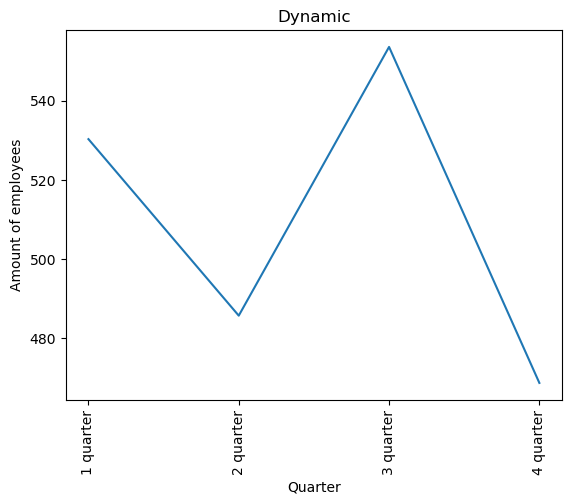

Percentage'Total': -11.62%


-11.616066377522152

In [54]:
employee_percentage(df_rk_g_accepted,'Total')

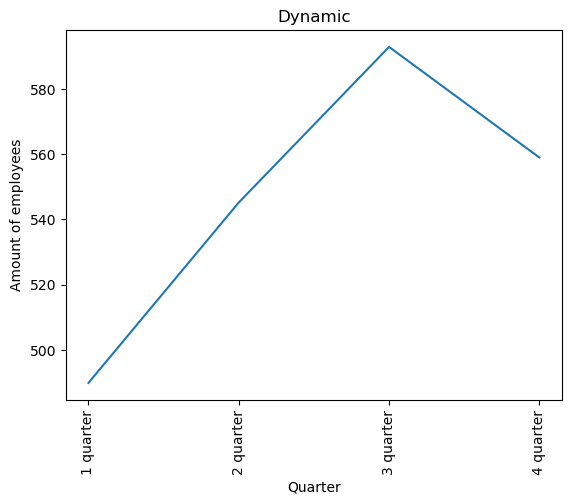

Percentage'Total': 14.10%


14.10491937130027

In [55]:
employee_percentage(df_rk_g_quitted,'Total')

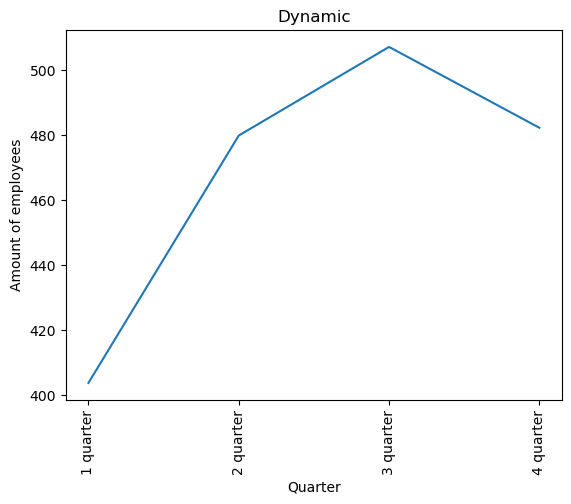

Percentage'Total': 19.47%


19.469903393609123

In [56]:
employee_percentage(df_rk_g_turnover,'Total')

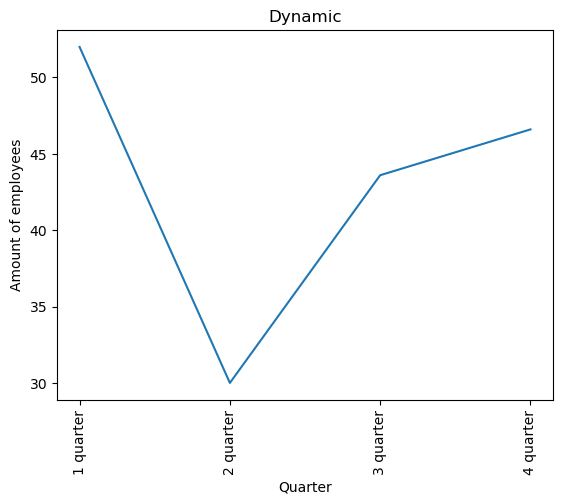

Percentage'Total': -10.38%


-10.384615384615383

In [57]:
employee_percentage(df_rk_g_cuts,'Total')

# Кластерний аналіз заробітних плат

In [58]:
def clusterize_dataframe(df):
    df = df.iloc[:, 1:]
    num_clusters = min(5, df.shape[1])
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df)
    cluster_labels = kmeans.labels_
    linkage_matrix = linkage(df.values.T, method='ward')
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, color_threshold=np.inf)
    plt.xlabel('Parameters')
    plt.xticks(rotation=90)
    plt.ylabel('Distance')
    plt.title('Dendrogram')
    plt.show()
    for i, column_name in enumerate(df.columns):
        print(f"Parameter: {column_name}, Cluster: {cluster_labels[i % num_clusters]}")

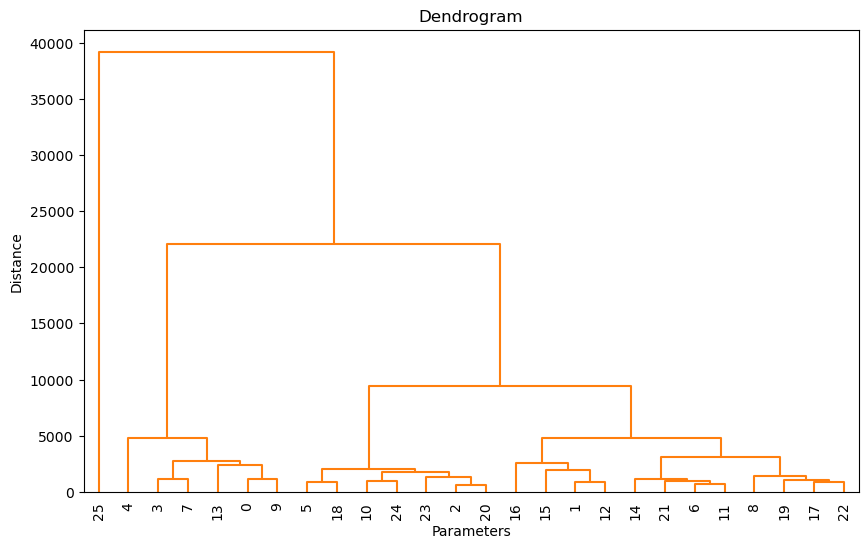

Parameter: Average by region, Cluster: 0
Parameter: Vinnytsya, Cluster: 0
Parameter: Volyn, Cluster: 4
Parameter: Dnipropetrovsk, Cluster: 3
Parameter: Donetsk, Cluster: 3
Parameter: Zhytomyr, Cluster: 0
Parameter: Zakarpattya, Cluster: 0
Parameter: Zaporizhzhya, Cluster: 4
Parameter: Ivano-Frankivsk, Cluster: 3
Parameter: Kyiv, Cluster: 3
Parameter: Kirovohrad, Cluster: 0
Parameter: Luhansk, Cluster: 0
Parameter: Lviv, Cluster: 4
Parameter: Mykolayiv, Cluster: 3
Parameter: Odesa, Cluster: 3
Parameter: Poltava, Cluster: 0
Parameter: Rivne, Cluster: 0
Parameter: Sumy, Cluster: 4
Parameter: Ternopil, Cluster: 3
Parameter: Kharkiv, Cluster: 3
Parameter: Kherson, Cluster: 0
Parameter: Khmelnytskiy, Cluster: 0
Parameter: Cherkasy, Cluster: 4
Parameter: Chernivtsi, Cluster: 3
Parameter: Chernihiv, Cluster: 3
Parameter: City of Kyiv, Cluster: 0


In [59]:
clusterize_dataframe(df_zp_r)

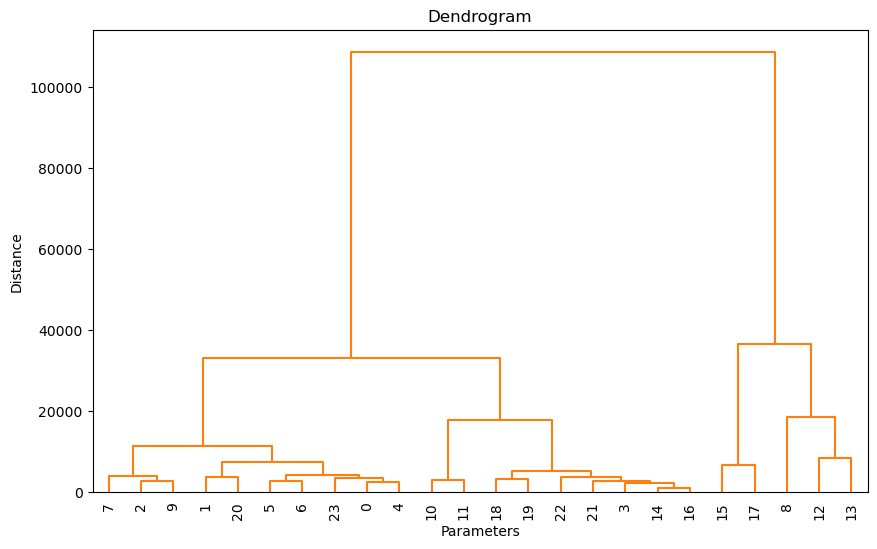

Parameter: Average by type of activity, Cluster: 3
Parameter: Agriculture, forestry and fishing , Cluster: 3
Parameter: Manufacturing, Cluster: 2
Parameter: Construction, Cluster: 2
Parameter: Wholesale and retail trade; repair of motor vehicles and motorcycles , Cluster: 0
Parameter: Transportation and warehousing, postal and courier activities, Cluster: 3
Parameter: Land transport and transport via pipelines, Cluster: 3
Parameter: Water transport, Cluster: 2
Parameter: Air transport, Cluster: 2
Parameter: Warehousing and support activities for transportation, Cluster: 0
Parameter: Postal and courier activities, Cluster: 3
Parameter: Accommodation and food service activities , Cluster: 3
Parameter: Information and communication , Cluster: 2
Parameter: Financial and insurance activities , Cluster: 2
Parameter: Real estate activities , Cluster: 0
Parameter: Professional, scientific and technical activities , Cluster: 3
Parameter: Administrative and support service activities , Cluster: 

In [60]:
clusterize_dataframe(df_zp_g)

# Перетворю датафрейми по зп з помісячних в поквартальні

In [61]:
df_zp_g_q=convert_to_quarters(df_zp_g)
df_zp_r_q=convert_to_quarters(df_zp_r)
df_zp_men_q=convert_to_quarters(df_zp_men)
df_zp_women_q=convert_to_quarters(df_zp_women)

# Побудова емпіричних функцій за допомогою МНК та розрахунок коефіцієнтів апроксимації

In [62]:
def function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def least_squares_approximation(df, x_column, y_column):
    df = df.drop(df.columns[0], axis=1)
    x = df[x_column].values
    y = df[y_column].values
    print(x)
    print(y)
    popt, _ = curve_fit(function, x, y)
    a = popt[0]
    b = popt[1]
    c = popt[2]
    d = popt[3]
    print(f'Coefficient a: {a}')
    print(f'Coefficient b: {b}')
    print(f'Coefficient c: {c}')
    print(f'Coefficient d: {d}')
    smooth_x = np.linspace(x.min(), x.max(), 100)
    plt.plot(smooth_x, function(smooth_x, a, b, c, d), color='r', label='Approximation')
    plt.plot(x, y, marker='o', linestyle='', label='Data')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.legend()
    plt.show()

In [65]:
temp_df=create_temp_df(df_zp_g_q,df_rk_g_accepted,'Average by type of activity','Total','Quarter')
display_full(temp_df)

,Quarter,Average by type of activity,Total
0,1 quarter,"38,497.84",530.30
1,2 quarter,"41,354.87",485.70
2,3 quarter,"42,581.43",553.60
3,4 quarter,"45,780.22",468.70


[38497.84 41354.87 42581.43 45780.22]
[530.3 485.7 553.6 468.7]
Coefficient a: -4.927765579473489e-09
Coefficient b: 0.0006207057360997214
Coefficient c: -26.004332197849553
Coefficient d: 362866.6977852065


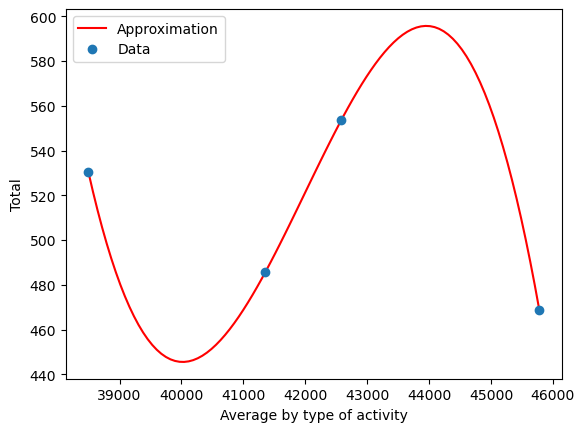

In [66]:
least_squares_approximation(temp_df,'Average by type of activity','Total')